the plan in this notebook is to begin exploring the use of funding to predict returns, i will also point out problems along the way and (mabye publicly) deal with them in future notebooks

note that im not going to have much text during this - mostly because its so graph heavy there isnt need, youll probably know what the text will say before you read it

In [49]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [50]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

In [51]:
# editing to remove what wont yet include returns and final day
df = df[df.groupby('asset').cumcount() > 0].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding]
Index: []


In [52]:
idx_max = df["next_returns_funding"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding"].idxmin()
print(df.loc[idx_min])

timestamp               2025-05-07 20:00:00
asset                           MOODENG-USD
open                                0.03772
high                                0.06749
low                                 0.03772
close                               0.06609
volume                           34510390.0
funding                            0.000036
funding inaccurate                       24
returns                            0.752121
returns_funding                    0.752085
next_returns_funding               1.070981
Name: 7811, dtype: object
timestamp               2025-08-30 20:00:00
asset                               XPL-USD
open                                0.72323
high                                0.87782
low                                 0.71167
close                               0.87562
volume                            2327003.0
funding                           -0.009813
funding inaccurate                       24
returns                            0.210708
return

In [53]:
# create funding deciles
df["funding_decile"] = 0

# per day deciles across all assets
df['funding_decile'] = df.groupby('timestamp')['funding'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
1     2024-12-07 20:00:00  1000BONK-USD       0.043347       0.043347   
417   2024-12-07 20:00:00  1000PEPE-USD       0.026459       0.027093   
707   2024-12-07 20:00:00  1000SHIB-USD       0.030642       0.030642   
1356  2024-12-07 20:00:00       ADA-USD       1.233100       1.233100   
1797  2024-12-07 20:00:00       ARB-USD       1.173200       1.185800   
2216  2024-12-07 20:00:00      AVAX-USD      52.310000      53.250000   
2854  2024-12-07 20:00:00       BNB-USD     761.100000     761.100000   
3277  2024-12-07 20:00:00       BTC-USD  100120.200000  100448.200000   
3725  2024-12-07 20:00:00      DOGE-USD       0.458750       0.483400   
4420  2024-12-07 20:00:00       ETH-USD    4023.260000    4023.260000   
4966  2024-12-07 20:00:00      GOAT-USD       0.780800       0.780800   
6696  2024-12-07 20:00:00      LINK-USD      24.812000      27.423000   
7102  2024-12-07 20:00:00       LTC-USD     133.760

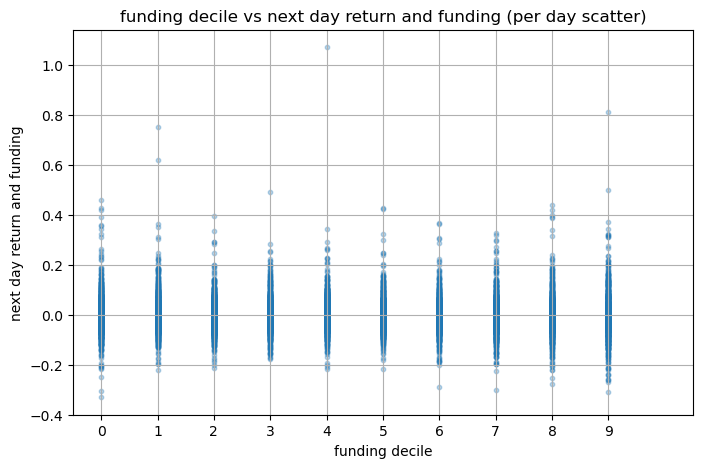

In [54]:
# scatter plot to gain initial intuiton
plt.figure(figsize=(8,5))
plt.scatter(
    df["funding_decile"], 
    df["next_returns_funding"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("funding decile")
plt.ylabel("next day return and funding")
plt.title("funding decile vs next day return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

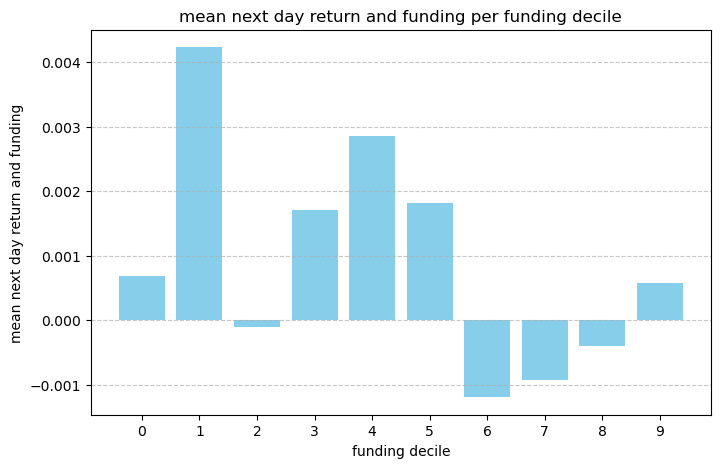

In [55]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("funding_decile")["next_returns_funding"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

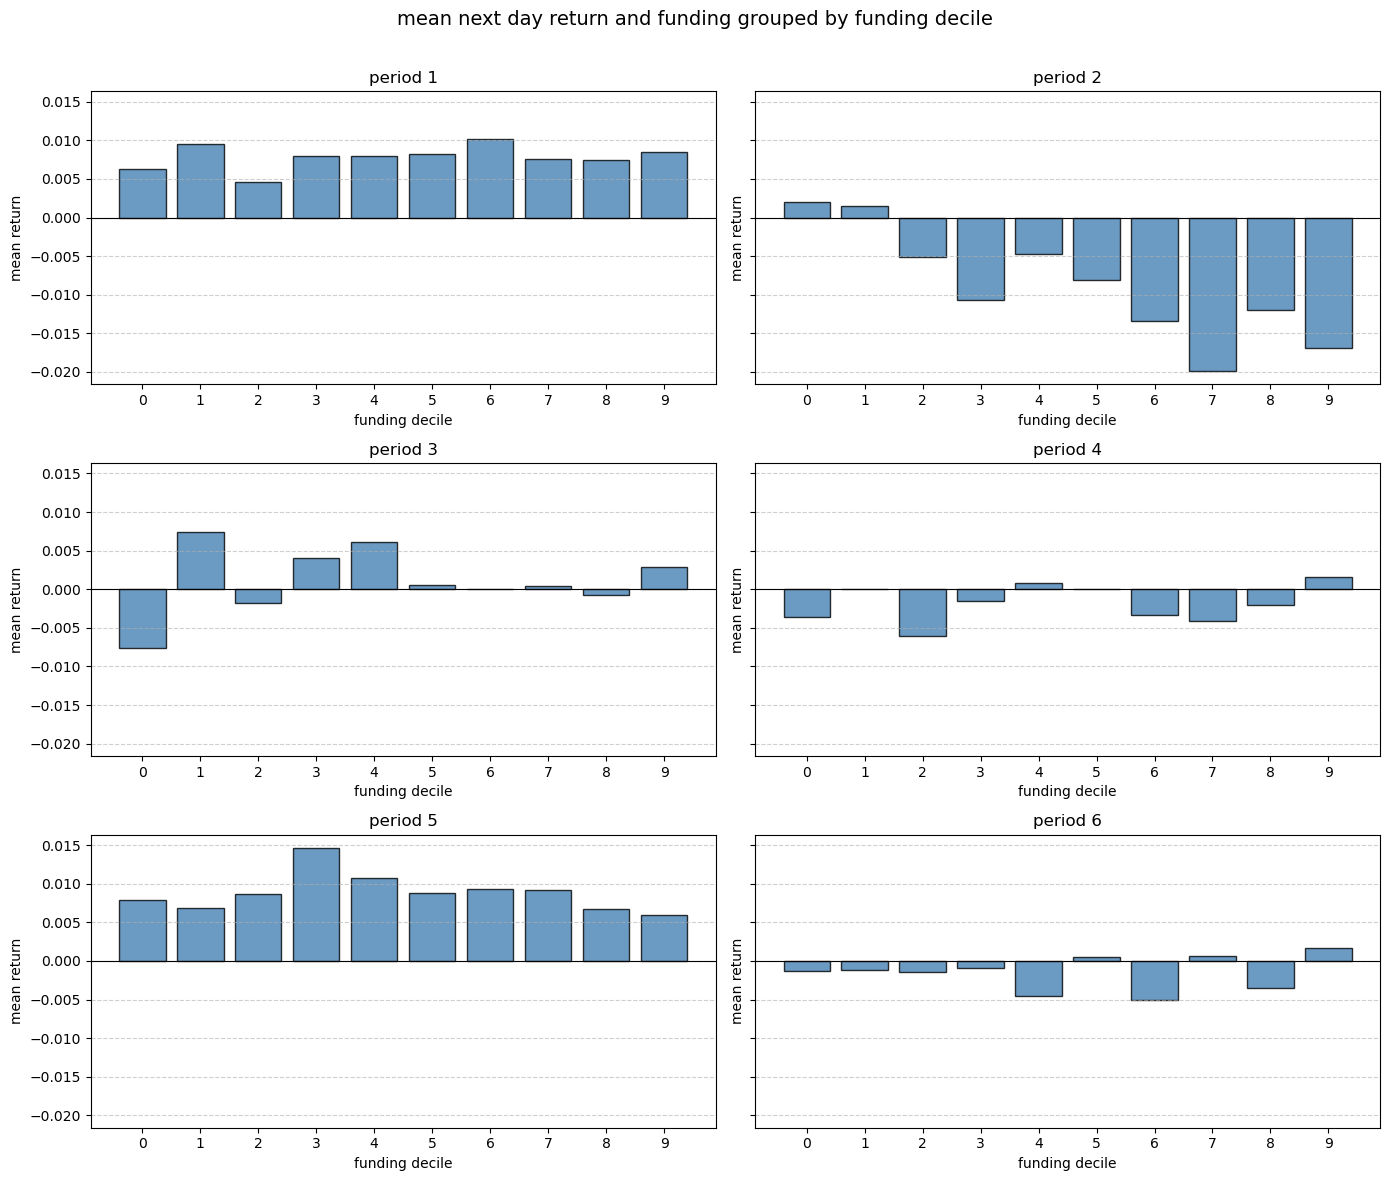

In [56]:
# checking deciles by periods
df["period"] = pd.qcut(df["timestamp"].rank(method="first"), 6, labels=False) + 1

# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    decile_means = subset.groupby("funding_decile")["next_returns_funding"].mean()
    
    bars = ax.bar(decile_means.index, decile_means.values, 
                  color="steelblue", edgecolor="black", alpha=0.8)
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("funding decile")
    ax.set_ylabel("mean return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(decile_means.index)

plt.suptitle("mean next day return and funding grouped by funding decile", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

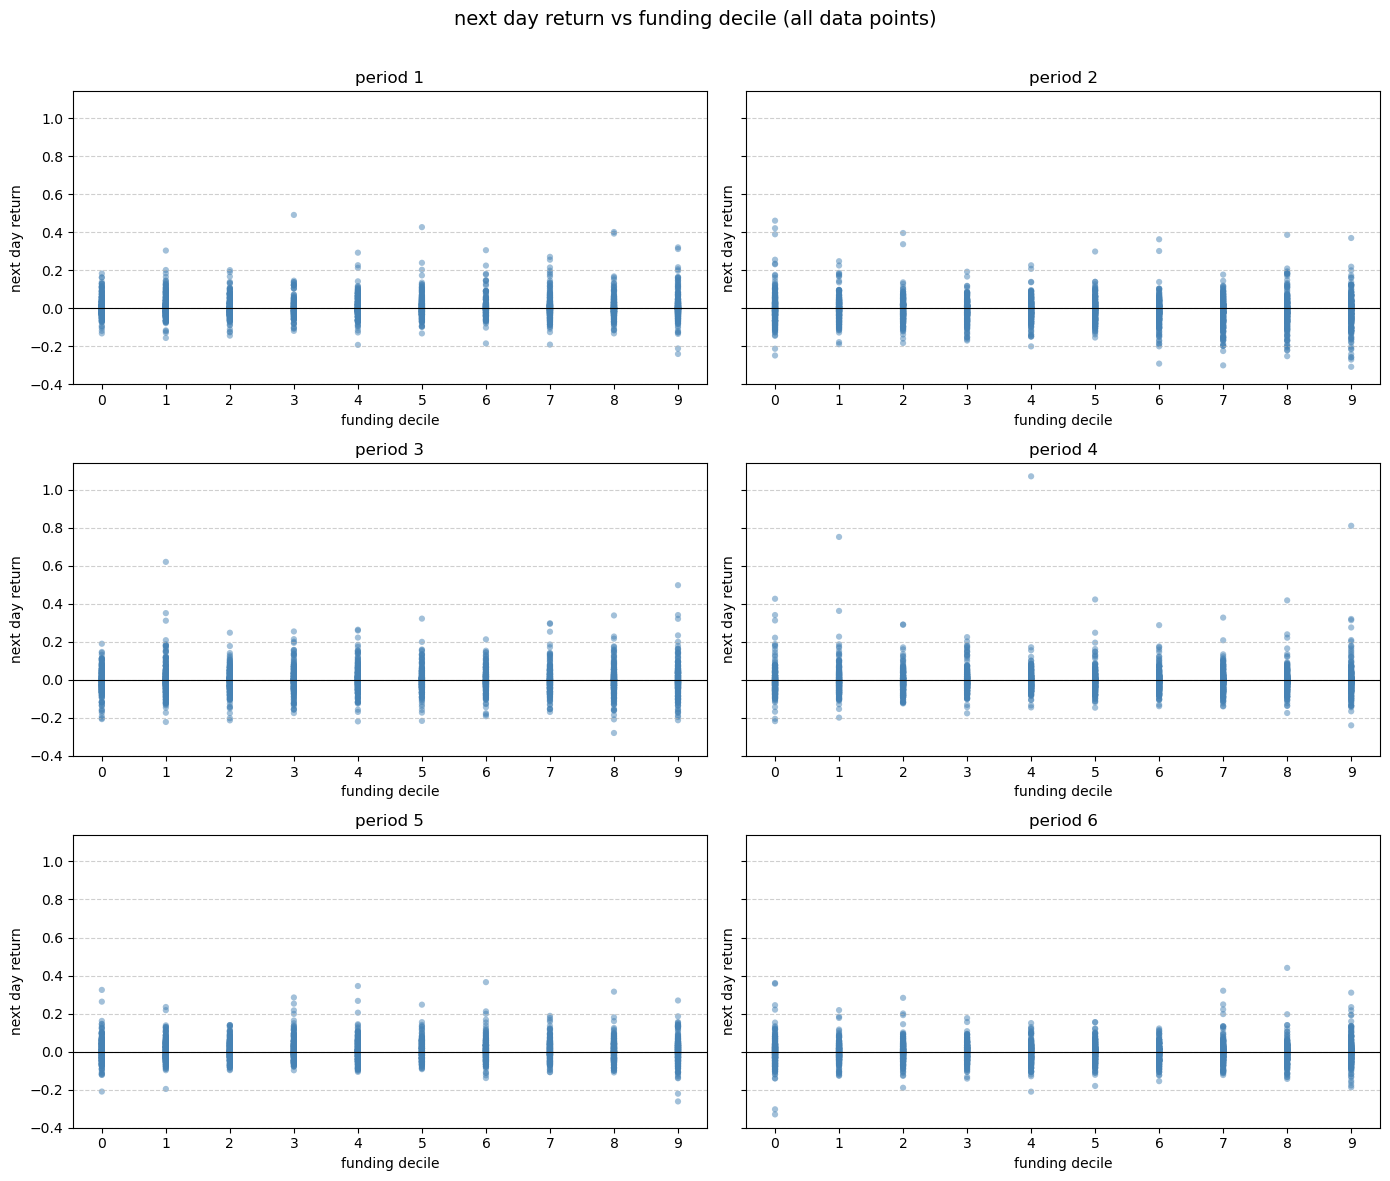

In [57]:
# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    
    # scatter all data points
    ax.scatter(subset["funding_decile"], subset["next_returns_funding"], 
               color="steelblue", alpha=0.5, s=20, edgecolor="none")
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("funding decile")
    ax.set_ylabel("next day return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(sorted(df["funding_decile"].unique()))

plt.suptitle("next day return vs funding decile (all data points)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

so far it seems the previous days funding rate has predictive power but outliers seem to be influencing returns - will check this out now by dropping the top and bottom 2% of returns and checking againn

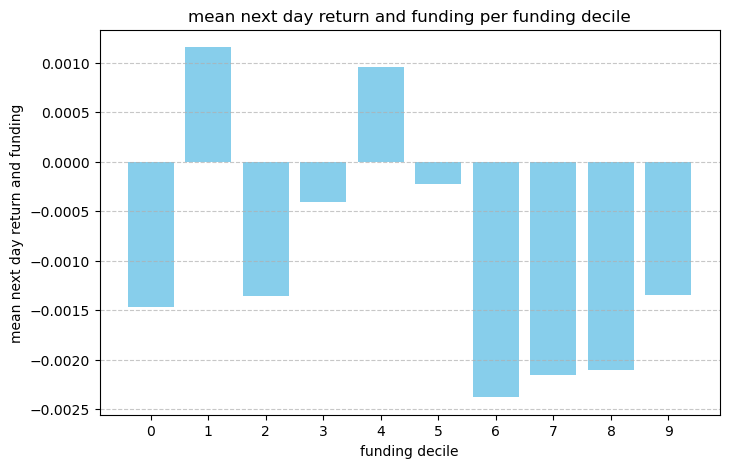

In [58]:
decile_means_v2 = (
    df.groupby("funding_decile")["next_returns_funding"]
      .apply(lambda g: g[
          (g >= g.quantile(0.05)) &
          (g <= g.quantile(0.95))
      ].mean())
)

plt.figure(figsize=(8,5))
plt.bar(decile_means_v2.index, decile_means_v2.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means_v2.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

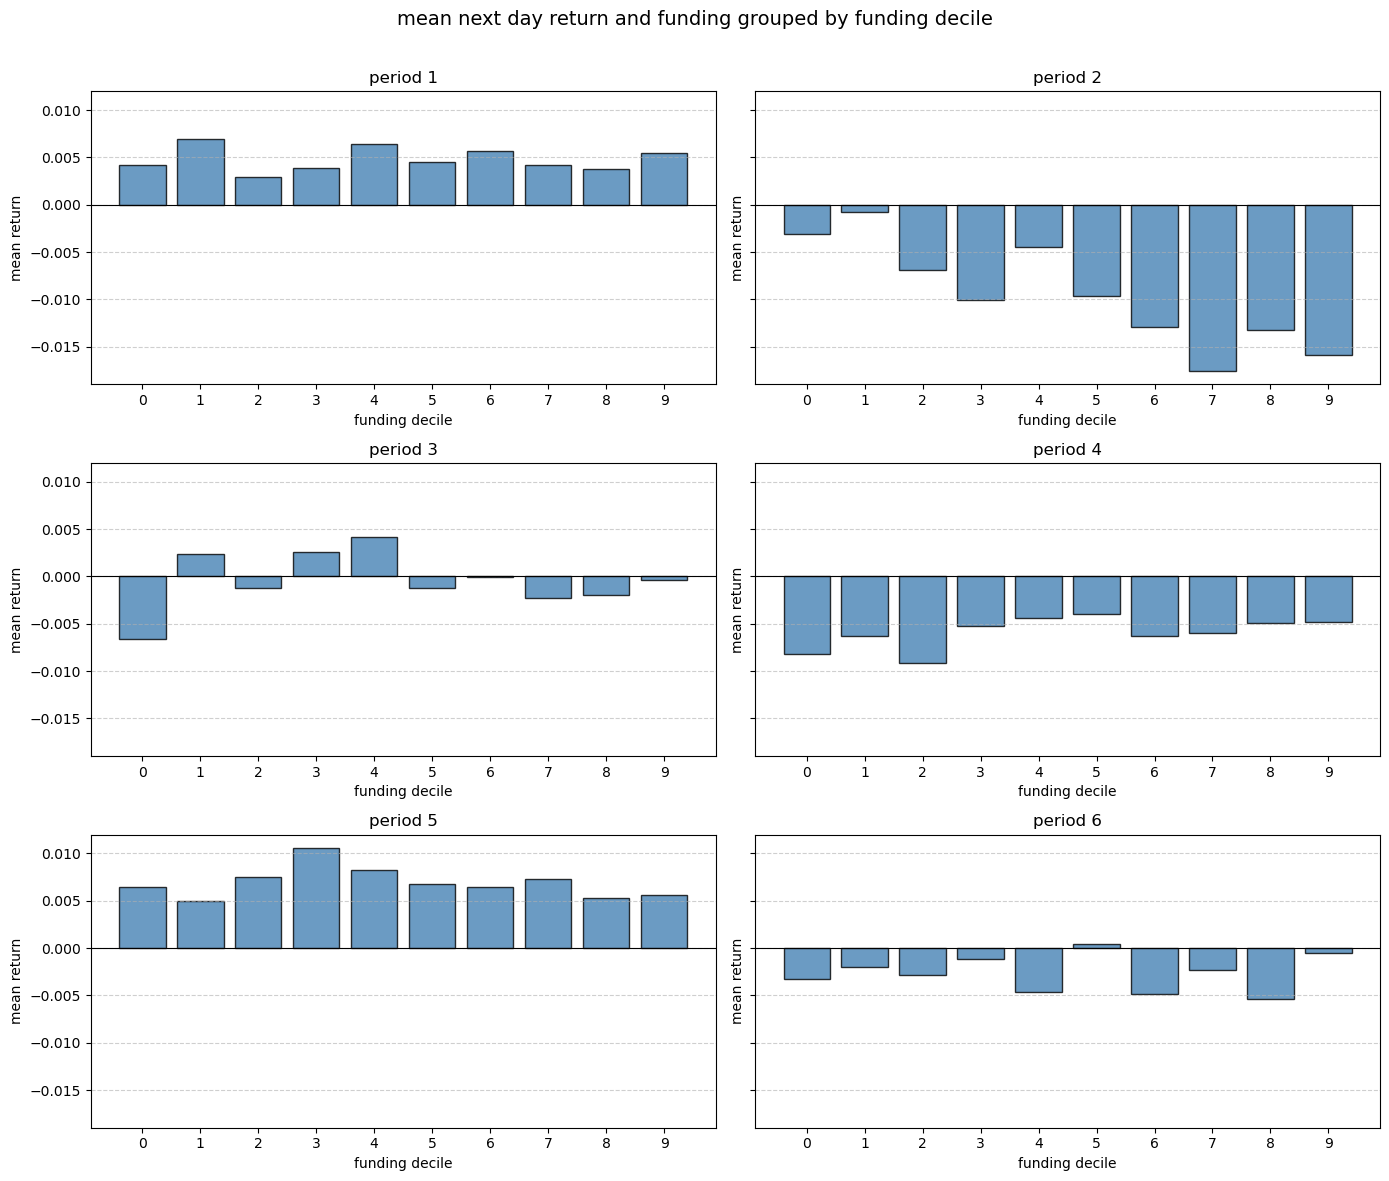

In [59]:
# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    decile_means = (
        subset.groupby("funding_decile")["next_returns_funding"]
        .apply(lambda g: g[
          (g >= g.quantile(0.05)) &
          (g <= g.quantile(0.95))
        ].mean())
    )   
    bars = ax.bar(decile_means.index, decile_means.values, 
                  color="steelblue", edgecolor="black", alpha=0.8)
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("funding decile")
    ax.set_ylabel("mean return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(decile_means.index)

plt.suptitle("mean next day return and funding grouped by funding decile", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

okay it seems now that they probably are having a big effect on returns  
should clarify why this is a problem:

- im going to solo trade this in a retail manner which invites imperfection (think of late fill times vs signal time and such) so even if im going to continue to get these outliers that seemingly make up a big part of pnl (naive to think) i cant even guarentee i will monetise them efficiently

- im making money here by betting on the mean return i see being roughly what the mean return is in the future and accepting variance of returns around this mean as my risk (or lucky reward depending on how they come) - the outliers are increasing my mean return in a way that isnt stable but also increasing my variance which i dont want, so from a pessimistic view the best case is theyre giving me false hope and worst case is theyll wipe my account out